In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 100 #higher precision
from scipy.optimize import curve_fit

In [2]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import pandas as pd


mp.mp.dps = 100

T_c = 2/(np.log(1+np.sqrt(2)))
T = np.linspace(T_c - 0.5 , T_c + 0.5, 20)

X_vals = [4, 6, 8]

Y_vals = [8, 10, 12, 14, 16]

probs = [0]

alpha=0.8

beta=0.000001

walker_wl=8

overlap_wl=0.25

seed_hist=1

seed_run=42

num_interactions=100

replica_exchange_steps=50

boundary_type=0

boundary = {0: "periodic", 1: "open", 2: "cylinder"}

intervals_wl=[20]

iterations=[5000]

num_walker_prerun=150

num_intervals_prerun=30

end_seed=((seed_hist + num_interactions - 1))

# ------------------------------------------------------------

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")

    return data

def fit_function_square(N, a,b,c,d,e):
    M = N
    S = M*N
    return a + b*(M+N)/S + c*np.log(S)/S + d*1/S + e*1/np.power(S,3/2) # + ... higher order terms

def linear_fit(x, m, b):
    return m * x + b

def fit_function_cylinder(N, a,b,c):
    return a + b/N**2 + c/N**4 # + ... higher order terms


def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res


def get_c_term_cylinder(f_lst, N_lst):
    fit = curve_fit(fit_function_cylinder, N_lst, f_lst)
    parameters = fit[0]
    c_term = parameters[1]*6/np.pi/(-T_c)
    return c_term

def process_data(data, batch_results: list, p, x, y, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'x': x,
                'y': y,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })

# ------------------------------------------------------
# Reading results here

results = []
for interval in intervals_wl:
    for iteration in iterations:
        for x in X_vals:
            for y in Y_vals:
                for p in probs:
                    res = []
                    for error in ["I"]:
                        filename = f"../results/{boundary[boundary_type]}/prob_{p:.6f}/X_{x}_Y_{y}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iteration}_overlap_{overlap_wl:.6f}_walkers_{walker_wl}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{replica_exchange_steps}.txt"
                        try:
                            data = read_results_file(filename)
                            if data:
                                process_data(data, results, p, x, y, error)
                        except:
                            print(f"not found: {filename}")

results_df = pd.DataFrame()
for t in T:
    results_t_df = pd.DataFrame(results)
    results_t_df['free_energy'] = results_t_df.apply(lambda row: free_energy(row['E'], row['log_g'], t), axis=1)
    results_t_df['temp'] = t
    results_t_df['free_energy'] = results_t_df['free_energy'].astype(float)
    results_df = pd.concat([results_df, results_t_df], ignore_index=True)


# Group by 'prob', 'x', 'y', 'error', 'temp' and calculate both mean and variance
aggregated_results_df = results_df.groupby(['prob', 'x', 'y', 'error', 'temp']).agg(
    avg_free_energy=('free_energy', 'mean'),
    var_free_energy=('free_energy', 'var')
).reset_index()

# Calculate the exponential ratio for extrapolating y -> inf limit but with scaling dimension 1?
aggregated_results_df['exp_ratio'] = np.exp(-2 * np.pi * aggregated_results_df['x'] / aggregated_results_df['y']) / (aggregated_results_df['y'] * aggregated_results_df['x'])


# Group the data by unique pairs of 'x' and 'temp'
unique_pairs = results_df.groupby(['x', 'temp']).size().reset_index().drop(columns=0)

# List to store extrapolated intercepts
intercepts_data = []

# # Create a plot for the extrapolation
# plt.figure(figsize=(8, 6))

# Iterate over each unique pair of (x, temp)
for _, (x_val, t_val) in unique_pairs.iterrows():
    # Filter the DataFrame for the specific x and temperature
    subset_df = aggregated_results_df[(aggregated_results_df['x'] == x_val) & (aggregated_results_df['temp'] == t_val)]

    # Ensure there are enough data points to fit
    if len(subset_df) > 1:
        exp_ratios = subset_df['exp_ratio']
        avg_free_energies = subset_df['avg_free_energy'] / (x_val * subset_df['y'])
        errors = np.sqrt(subset_df['var_free_energy']) / (x_val * subset_df['y'])

        # Fit a linear model to the data points (exp_ratio vs avg_free_energy)
        popt, pcov = curve_fit(linear_fit, exp_ratios, avg_free_energies)

        # Extrapolate to find the y-intercept (where exp_ratio = 0)
        y_intercept = linear_fit(0, *popt)

        # Calculate the variance of the intercept estimate
        # The variance of the parameters can be found in the covariance matrix (pcov)
        intercept_variance = pcov[0, 0]  # Assuming popt[0] is the intercept
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the x, t, and intercept data
        intercepts_data.append({
            'x_value': x_val,
            'temp_value': t_val,
            'intercept_free_energy': y_intercept,
            'intercept_variance': intercept_variance,
            'intercept_std_dev': intercept_std_dev
        })

        # # Plot the original points with error bars
        # plt.errorbar(
        #     exp_ratios,
        #     avg_free_energies,
        #     yerr=errors,
        #     fmt='o', capsize=5, label=f'X: {x_val}, T: {t_val}', color=np.random.rand(3,)
        # )

        # # Plot the linear fit over the entire exp_ratio range (extrapolated)
        # x_vals_for_line = np.linspace(0, max(exp_ratios) * 2, 100)  # Extended range for the line
        # plt.plot(x_vals_for_line, linear_fit(x_vals_for_line, *popt), linestyle='--', color='gray')

        # # Mark the y-intercept on the plot
        # plt.scatter(0, y_intercept, color='red', zorder=5)
        # plt.text(0, y_intercept, f'X: {x_val}, T: {t_val}, Intercept: {y_intercept:.2f}', fontsize=9, ha='left', va='bottom')

# Create a DataFrame to store the intercept results
intercepts_df = pd.DataFrame(intercepts_data)

# # Add labels and title to the plot
# plt.xlabel('Exponential Ratio')
# plt.ylabel('Averaged Free Energy')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

# Display the intercepts DataFrame
print(intercepts_df)

not found: ../results/periodic/prob_0.000000/X_4_Y_10/error_class_I/StitchedHistogram_intervals_20_iterations_5000_overlap_0.250000_walkers_8_alpha_0.800000_beta_0.0000010000_exchange_offset50.txt
    x_value  temp_value  intercept_free_energy  intercept_variance  \
0       4.0    1.769185              -2.074793            0.105692   
1       4.0    1.821817              -2.081055            0.117212   
2       4.0    1.874448              -2.087977            0.132058   
3       4.0    1.927080              -2.095621            0.150843   
4       4.0    1.979712              -2.104051            0.173476   
5       4.0    2.032343              -2.113339            0.198681   
6       4.0    2.084975              -2.123556            0.223792   
7       4.0    2.137606              -2.134773            0.245084   
8       4.0    2.190238              -2.147053            0.258684   
9       4.0    2.242870              -2.160449            0.261701   
10      4.0    2.295501          

In [3]:
intercepts_df

,x_value,temp_value,intercept_free_energy,intercept_variance,intercept_std_dev
0,4.0,1.769185,-2.074793,0.105692,0.325103
1,4.0,1.821817,-2.081055,0.117212,0.342362
2,4.0,1.874448,-2.087977,0.132058,0.363398
3,4.0,1.927080,-2.095621,0.150843,0.388385
4,4.0,1.979712,-2.104051,0.173476,0.416505
5,4.0,2.032343,-2.113339,0.198681,0.445736
6,4.0,2.084975,-2.123556,0.223792,0.473067
7,4.0,2.137606,-2.134773,0.245084,0.495060
8,4.0,2.190238,-2.147053,0.258684,0.508610
9,4.0,2.242870,-2.160449,0.261701,0.511567


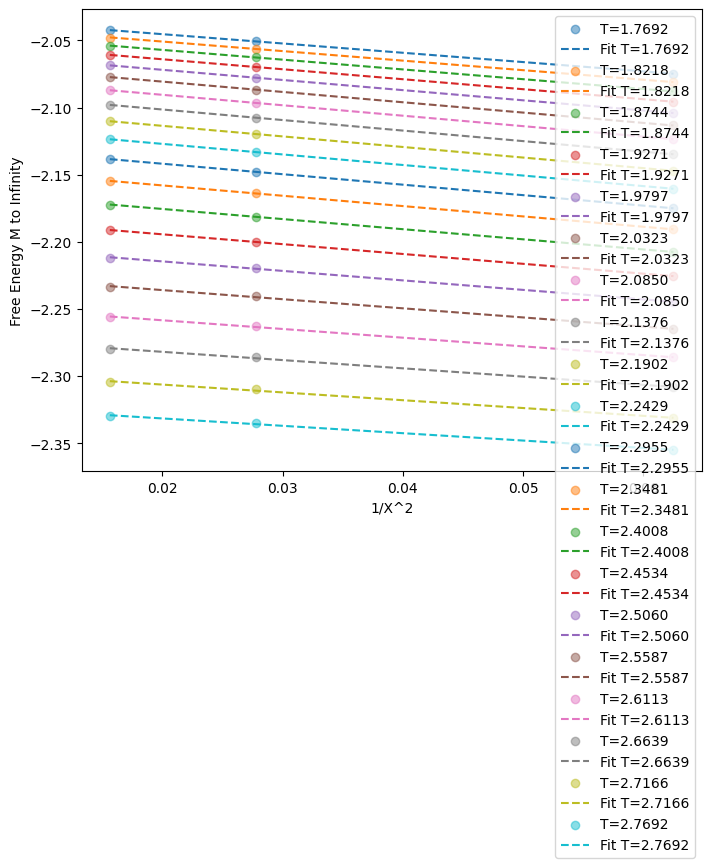

In [4]:
# Get central charge by linear fit of 1/N**2 dependency
c=[]

intercepts_df['inverse_x_squared'] = 1 / (intercepts_df['x_value'] ** 2)

unique_temps = intercepts_df['temp_value'].unique()

plt.figure(figsize=(8, 6))


for t_val in unique_temps:
    temp_df = intercepts_df[intercepts_df['temp_value'] == t_val]
    if len(temp_df) > 1:
#---------------------
        popt, pcov = curve_fit(linear_fit, temp_df['inverse_x_squared'], temp_df['intercept_free_energy'])

        # Extract slope and intercept variances
        slope_variance, intercept_variance = np.diag(pcov)
        slope_std_dev = np.sqrt(slope_variance)
        intercept_std_dev = np.sqrt(intercept_variance)

        # Store the results
        c.append({
            'temp': t_val,
            'slope': popt[0],
            'intercept': popt[1],
            'slope_std_dev': slope_std_dev,
            'intercept_std_dev': intercept_std_dev
        })

        # Generate x values for plotting the fit line
        x_fit = np.linspace(min(temp_df['inverse_x_squared']), max(temp_df['inverse_x_squared']), 100)
        y_fit = linear_fit(x_fit, *popt)

        plt.scatter(temp_df['inverse_x_squared'], temp_df['intercept_free_energy'], label=f'T={t_val:.4f}', alpha=0.5)
        # plt.errorbar(temp_df['inverse_x_squared'], temp_df['free_energy_M_to_inf'], yerr=intercept_std_dev, fmt='o', color=colors[T.index(t_val)], label=f'T={t_val}', capsize=5)
        plt.plot(x_fit, y_fit, linestyle='--', label=f'Fit T={t_val:.4f}')

# Final plot adjustments
plt.xlabel('1/X^2')
plt.ylabel('Free Energy M to Infinity')
plt.grid(False)
plt.legend()

# Show the plot
plt.show()
#----------------------


In [5]:
for res in c:
    res['c']=-6*res['slope']/(res['temp']*mp.pi)

c_df = pd.DataFrame(c)

In [6]:
c_df

,temp,slope,intercept,slope_std_dev,intercept_std_dev,c
0,1.769185,-0.692674,-2.031463,0.005427,0.000220,0.74775076216237473847967170110640128712679046...
1,1.821817,-0.710754,-2.036600,0.004700,0.000190,0.74510254525358369017376229651071624234157933...
2,1.874448,-0.727734,-2.042468,0.003705,0.000150,0.74148186373625737132253917736450859434886533...
3,1.927080,-0.743328,-2.049146,0.002454,0.000099,0.73668561441886595807301670102506055961922280...
4,1.979712,-0.757221,-2.056718,0.001018,0.000041,0.73050345981729745147123594540248013379909077...
5,2.032343,-0.769060,-2.065276,0.000462,0.000019,0.72271077704097721184352253541974699691909595...
6,2.084975,-0.778432,-2.074917,0.001782,0.000072,0.71305180634952964241817686329106172153675694...
7,2.137606,-0.784849,-2.085739,0.002689,0.000109,0.70122847264871317133676782724649561323848313...
8,2.190238,-0.787747,-2.097840,0.002933,0.000119,0.68690498599739520561180629912092925076215357...
9,2.242870,-0.786525,-2.111307,0.002301,0.000093,0.66974536140875850599779903435292197849336468...


/tmp/ipykernel_1929322/4173163654.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


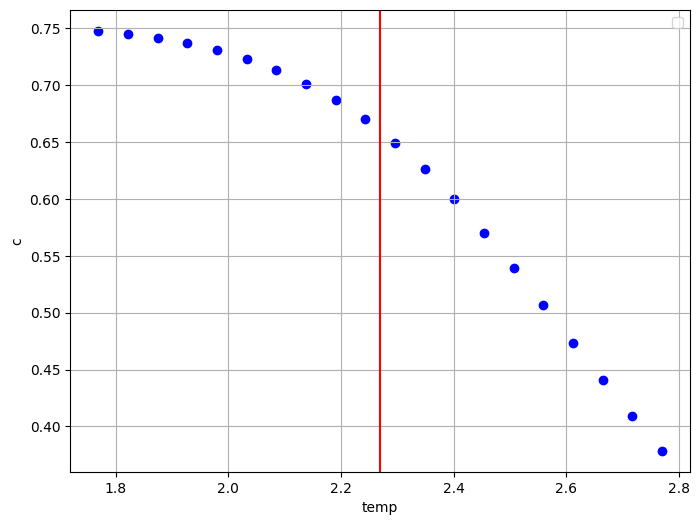

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter( c_df['temp'], c_df['c'], color='blue')
plt.xlabel('temp')
plt.ylabel('c')
plt.axvline(x=T_c, color='red')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
plt.figure(figsize=(8, 6))
unique_x = aggregated_results_df['x'].unique()
# for x in unique_x
# plt.scatter( intercepts_df['temp'], intercepts_df['free_energy_M_to_inf'], color='blue')
# plt.xlabel('temp')
# plt.ylabel('c')
# plt.axvline(x=T_c, color='red')
# plt.grid(True)
# plt.legend()
# plt.show()

<Figure size 800x600 with 0 Axes>